# Xception Pretrained Network no Fine Tuning 

In this run for the Xception, we froze all layers and added two dense layers after the conv_base.

Best Epoch: 8263

test acc: 0,88800

test loss: 3,21984

f1_score: 0,88951

Precision: 0,87767

Recall: 0,90166

ROC AUC: 0,88800

---Training:  seconds --- 22181.5 s

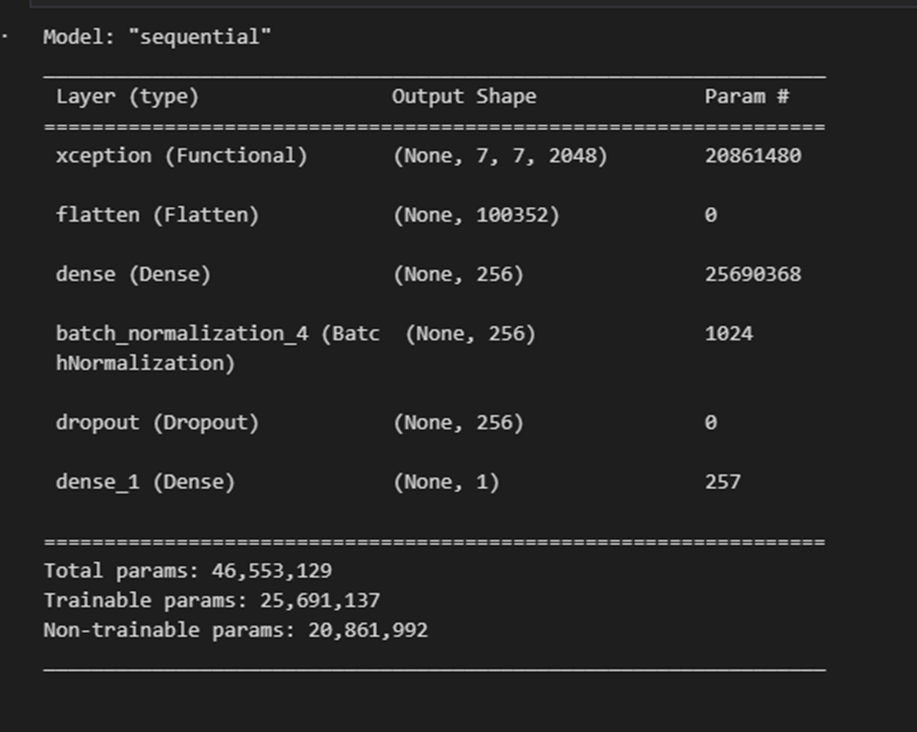

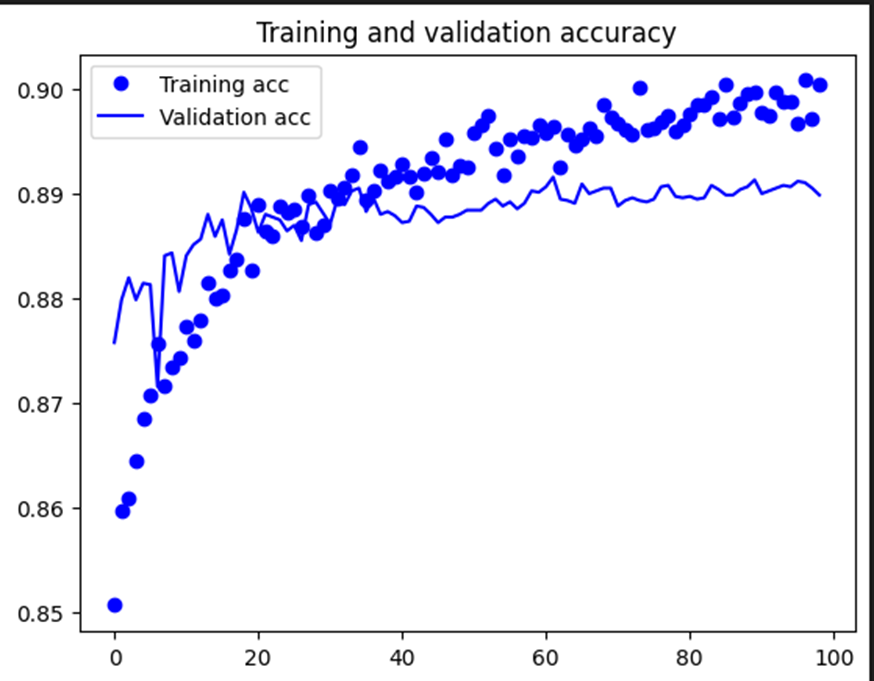

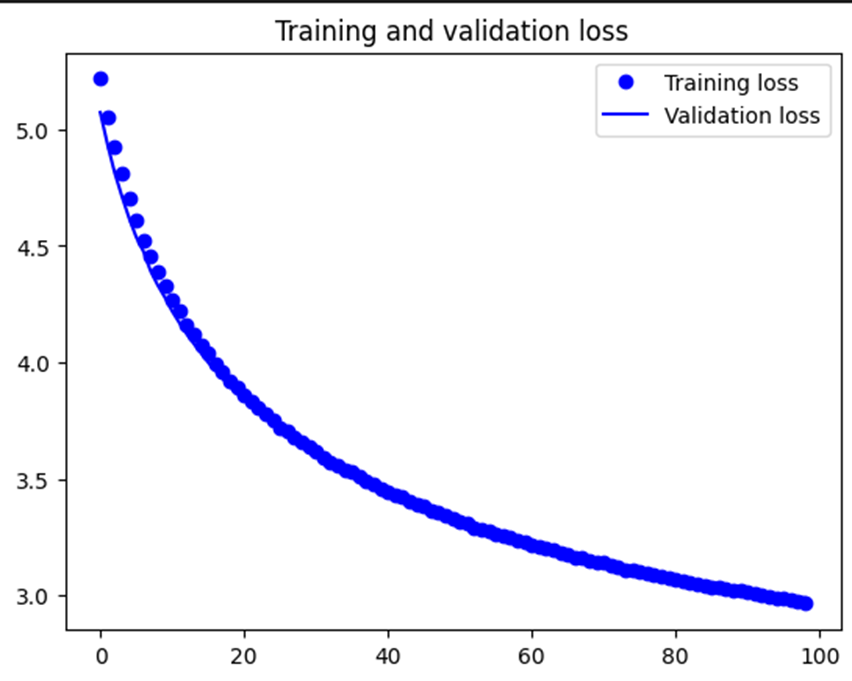

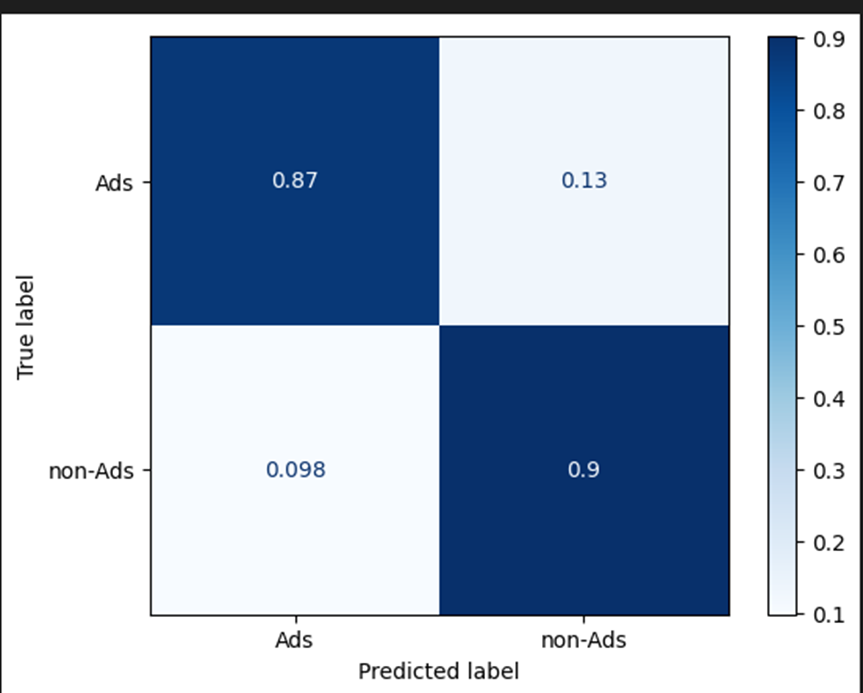

In [1]:
#!pip install "tensorflow<2.11"

In [2]:
#!pip install tensorflow tensorflow-gpu opencv-python matplotlib

In [3]:
#!pip install torchvision

In [4]:

#!pip list
import torch

In [5]:
#!nvidia-smi

In [6]:
#!pip install torch==1.10.1+cu113 torchvision==0.11.2+cu113 torchaudio===0.10.1+cu113 -f https://download.pytorch.org/whl/cu113/torch_stable.html

In [7]:
# add headings with ##(space) on the markdowns

In [8]:
#!pip install tensorflor keras

In [9]:
import tensorflow as tf
import os

In [10]:
!nvidia-smi

Sat Jun 22 13:40:10 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 536.67                 Driver Version: 536.67       CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                     TCC/WDDM  | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce GTX 1660 ...  WDDM  | 00000000:2D:00.0  On |                  N/A |
|  0%   49C    P8              17W / 125W |    854MiB /  6144MiB |     28%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [11]:
gpus = tf.config.experimental.list_physical_devices('GPU')
gpus

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [12]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [13]:
#! nvidia-smi

In [14]:
#!pip install opencv-python

## Imports

In [15]:
import tensorflow as tf
import os
import cv2
import imghdr

In [16]:
import numpy as np
from matplotlib import pyplot as plt

In [17]:
class TrainingConfig:
    BATCH_SIZE:       int   = 64
    EPOCHS:           int   = 100
    LEARNING_RATE:    float = 0.001
    DROPOUT:          float = 0.5
    #LAYERS_FINE_TUNE: int   = 4
    EPSILON:          float = 1e-07
    MOMENTUM:         float = 0.9   
    WEIGHT_DECAY:     float = 0.0005 

# Split Data

In [18]:
base_dir = r"C:\Users\YannisPC\PycharmProjects\Thesis\Thesis\READY_BALANCED_SAME_SIZE_Random_Split"

In [19]:
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')
test_dir = os.path.join(base_dir, 'test')

In [20]:
train_Ads_dir = os.path.join(train_dir, 'Ads')
train_sample_dir = os.path.join(train_dir, 'Sample')
train_Ads_dir

'C:\\Users\\YannisPC\\PycharmProjects\\Thesis\\Thesis\\READY_BALANCED_SAME_SIZE_Random_Split\\train\\Ads'

In [21]:
validation_Ads_dir = os.path.join(validation_dir, 'Ads')
validation_sample_dir = os.path.join(validation_dir, 'Sample')
validation_Ads_dir


'C:\\Users\\YannisPC\\PycharmProjects\\Thesis\\Thesis\\READY_BALANCED_SAME_SIZE_Random_Split\\validation\\Ads'

In [22]:
test_Ads_dir = os.path.join(test_dir, 'Ads')
test_sample_dir = os.path.join(test_dir, 'Sample')
test_Ads_dir

'C:\\Users\\YannisPC\\PycharmProjects\\Thesis\\Thesis\\READY_BALANCED_SAME_SIZE_Random_Split\\test\\Ads'

In [23]:
print('total training Ads images:', len(os.listdir(train_Ads_dir)))

total training Ads images: 10500


In [24]:
print('total training sample images:', len(os.listdir(train_sample_dir)))

total training sample images: 10500


In [25]:
print('total validation Ads images:', len(os.listdir(validation_Ads_dir)))

total validation Ads images: 3650


In [26]:
print('total validation sample images:', len(os.listdir(validation_sample_dir)))

total validation sample images: 3950


In [27]:
print('total test Ads images:', len(os.listdir(test_Ads_dir)))

total test Ads images: 3000


In [28]:
print('total test sample images:', len(os.listdir(test_sample_dir)))

total test sample images: 3000


## Using data augmentation/ datagen

In [29]:
import numpy as np
from PIL import ImageEnhance
from PIL import Image
from keras.preprocessing.image import ImageDataGenerator  
from tensorflow.keras.utils import img_to_array, array_to_img,  load_img

In [30]:
# Custom preprocessing function for color augmentation
def color_jitter(image):
    image = ImageEnhance.Brightness(image).enhance(np.random.uniform(0.4, 1.6)) # from -60% to +60%
    image = ImageEnhance.Contrast(image).enhance(np.random.uniform(0.4, 1.6))
    image = ImageEnhance.Color(image).enhance(np.random.uniform(0.4, 1.6))
    return image

In [31]:
# Custom preprocessing function for ImageDataGenerator
def custom_preprocessing_function(image):
    # Convert array to PIL image
    image = array_to_img(image)
    # Apply color jitter
    image = color_jitter(image)
    # Convert PIL image back to array
    image = img_to_array(image)
    return image

In [32]:
from keras.preprocessing.image import ImageDataGenerator

## with Augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    preprocessing_function=custom_preprocessing_function)


#train_datagen = ImageDataGenerator(
#    rescale=1./255)

# Note that the validation data should not be augmented!
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        # This is the target directory
        train_dir,
        # All images will be resized to 150x150
        target_size=(224, 224),
        batch_size=TrainingConfig.BATCH_SIZE, #32
        # Since we use binary_crossentropy loss, we need binary labels
        class_mode='binary')

validation_generator = test_datagen.flow_from_directory(
        validation_dir,
        target_size=(224, 224),
        batch_size=TrainingConfig.BATCH_SIZE,
        class_mode='binary')

Found 21000 images belonging to 2 classes.
Found 7600 images belonging to 2 classes.


## Pretrained Model Inception

In [33]:
import keras
from keras.models import load_model


# Appling a Pre-trained CNN on our Dataset for comparison

The Inception model
https://www.researchgate.net/figure/Inception-V3-pre-trained-neural-network-architecture-26-VGG-16-VGG-16-is-a-convolutional_fig2_344579619



In [34]:
from keras.applications import Xception

conv_base = Xception(weights='imagenet',
                 include_top=False,
                 input_shape=(224, 224, 3))

In [35]:
conv_base.summary()


Model: "xception"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 block1_conv1 (Conv2D)          (None, 111, 111, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 block1_conv1_bn (BatchNormaliz  (None, 111, 111, 32  128        ['block1_conv1[0][0]']           
 ation)                         )                                                          

We will add a dense layer after our conv_base NN

In [36]:
from keras import models
from keras import layers
from keras.regularizers import l2, l1
from keras.layers import Dense, Flatten, Dropout, BatchNormalization

modelPreTInc = models.Sequential()
modelPreTInc.add(conv_base)

modelPreTInc.add(layers.Flatten())
modelPreTInc.add(layers.Dense(256, activation='relu', kernel_regularizer=l2(0.01)))
modelPreTInc.add(BatchNormalization())
modelPreTInc.add(layers.Dropout(TrainingConfig.DROPOUT))
modelPreTInc.add(layers.Dense(1, activation='sigmoid'))

In [37]:
modelPreTInc.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 xception (Functional)       (None, 7, 7, 2048)        20861480  
                                                                 
 flatten (Flatten)           (None, 100352)            0         
                                                                 
 dense (Dense)               (None, 256)               25690368  
                                                                 
 batch_normalization_4 (Batc  (None, 256)              1024      
 hNormalization)                                                 
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 257       
                                                        

Before training the model, we need to separate the pretrained model from our DNN which is added on top of that. So that when we train our model we dont ruin the pretrained weights and biased of the Inception Model

In [38]:
print('This is the number of trainable layers '
      'before freezing the conv base:', len(modelPreTInc.trainable_weights))

This is the number of trainable layers before freezing the conv base: 160


In [39]:
conv_base.trainable = False

In [40]:
print('This is the number of trainable layers '
      'after freezing the conv base:', len(modelPreTInc.trainable_weights))

This is the number of trainable layers after freezing the conv base: 6


In [41]:
from keras import optimizers
adagrad = optimizers.Adagrad(learning_rate=TrainingConfig.LEARNING_RATE, initial_accumulator_value=0.1, epsilon=TrainingConfig.EPSILON, decay =TrainingConfig.WEIGHT_DECAY)

In [42]:
# add checkpoint to store the model on the best epoch for Val acc.
checkpoint_filepath = r'C:\Users\YannisPC\PycharmProjects\Thesis\Thesis\checkpoints\modelXcep-{epoch:02d}-{val_accuracy:.4f}.keras'
model_checkpoint_callback = keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True,
    verbose=1)

In [43]:
from keras.callbacks import ReduceLROnPlateau

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, min_lr=0.001) #Factor by which the learning rate will be reduced

In [44]:
modelPreTInc.compile(optimizer= adagrad, loss=tf.losses.BinaryCrossentropy(), metrics=[tf.keras.metrics.BinaryAccuracy(threshold=0.5, name='accuracy')])# metrics=['accuracy']


In [45]:
modelPreTInc.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 xception (Functional)       (None, 7, 7, 2048)        20861480  
                                                                 
 flatten (Flatten)           (None, 100352)            0         
                                                                 
 dense (Dense)               (None, 256)               25690368  
                                                                 
 batch_normalization_4 (Batc  (None, 256)              1024      
 hNormalization)                                                 
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 257       
                                                        

In [46]:
print(TrainingConfig.EPOCHS)

100


In [47]:
import time
start_time = time.time()

In [48]:
histPreT = modelPreTInc.fit(train_generator, epochs = TrainingConfig.EPOCHS, validation_data=validation_generator, callbacks=[model_checkpoint_callback, reduce_lr]) # 

Epoch 1/100
329/329 [==============================] - ETA: 0s - loss: 5.4609 - accuracy: 0.8249
Epoch 1: val_accuracy improved from -inf to 0.86066, saving model to C:\Users\YannisPC\PycharmProjects\Thesis\Thesis\checkpoints\modelXcep-01-0.8607.keras
329/329 [==============================] - 221s 654ms/step - loss: 5.4609 - accuracy: 0.8249 - val_loss: 5.2536 - val_accuracy: 0.8607 - lr: 0.0010
Epoch 2/100
329/329 [==============================] - ETA: 0s - loss: 5.2167 - accuracy: 0.8507
Epoch 2: val_accuracy improved from 0.86066 to 0.87579, saving model to C:\Users\YannisPC\PycharmProjects\Thesis\Thesis\checkpoints\modelXcep-02-0.8758.keras
329/329 [==============================] - 209s 633ms/step - loss: 5.2167 - accuracy: 0.8507 - val_loss: 5.0727 - val_accuracy: 0.8758 - lr: 0.0010
Epoch 3/100
329/329 [==============================] - ETA: 0s - loss: 5.0554 - accuracy: 0.8598
Epoch 3: val_accuracy improved from 0.87579 to 0.87987, saving model to C:\Users\YannisPC\PycharmPro

In [49]:
print("--- %s seconds ---" % (time.time() - start_time))

--- 22181.57153058052 seconds ---


In [50]:
#modelPreTInc.save(os.path.join('models/Latest','Pretrained_Inception_ad_class_no_Aug.h5'))

In [51]:
Current_dir = os.getcwd()
Current_dir

'c:\\Users\\YannisPC\\PycharmProjects\\Thesis\\Thesis'

In [52]:
os.path.join(Current_dir, 'History')

'c:\\Users\\YannisPC\\PycharmProjects\\Thesis\\Thesis\\History'

In [53]:
import pickle
with open(r'c:\\Users\\YannisPC\\PycharmProjects\\Thesis\\Thesis\\History\\HistoryDict_Xception_FT0', 'wb') as file_pi:
    pickle.dump(histPreT.history, file_pi)

In [54]:
val_acc_per_epoch = histPreT.history['val_accuracy']
best_epoch = val_acc_per_epoch.index(max(val_acc_per_epoch)) + 1
print('Best epoch: %d' % (best_epoch,))

Best epoch: 63


In [55]:
START_PLOT_FROM_EPOCH= 1

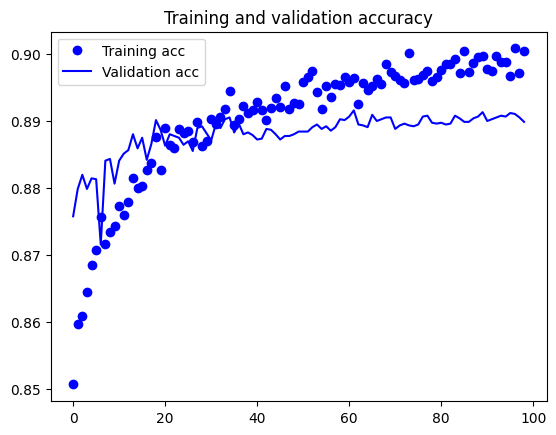

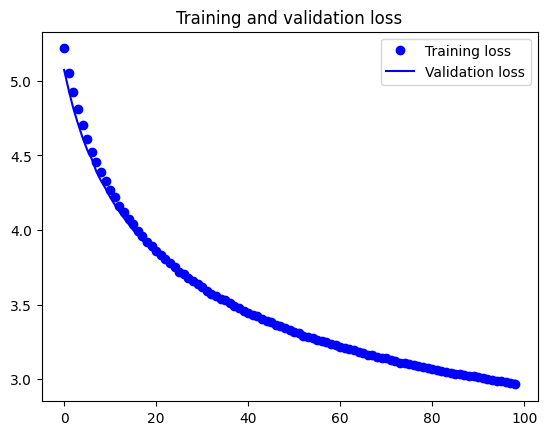

In [56]:
acc = histPreT.history['accuracy'][START_PLOT_FROM_EPOCH:]
val_acc = histPreT.history['val_accuracy'][START_PLOT_FROM_EPOCH:]
loss = histPreT.history['loss'][START_PLOT_FROM_EPOCH:]
val_loss = histPreT.history['val_loss'][START_PLOT_FROM_EPOCH:]

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [57]:
val_acc_per_epoch = histPreT.history['val_accuracy']
best_epoch = val_acc_per_epoch.index(max(val_acc_per_epoch)) + 1
print('Best epoch: %d' % (best_epoch,))

Best epoch: 63


# loading best epoch in our model using the checkpoints

In [58]:
best_val_accuracy = max(val_acc_per_epoch)
best_model_file = f'model-{best_epoch:02d}-{best_val_accuracy:.4f}.keras'

print(f'Best model file: {best_model_file}')

Best model file: model-63-0.8916.keras


In [59]:
model_dir= r'C:\Users\YannisPC\PycharmProjects\Thesis\Thesis\checkpoints' # C:\Users\YannisPC\PycharmProjects\Thesis\Thesis\checkpoints

In [60]:
# Construct the full path to the best model file
best_model_path = os.path.join(model_dir, best_model_file)
best_model_path

'C:\\Users\\YannisPC\\PycharmProjects\\Thesis\\Thesis\\checkpoints\\model-63-0.8916.keras'

In [61]:
os.chdir(model_dir)
Current_dir = os.getcwd()
Current_dir

'C:\\Users\\YannisPC\\PycharmProjects\\Thesis\\Thesis\\checkpoints'

In [62]:
from os import listdir
from os.path import isfile, join
onlyfiles = [f for f in listdir(model_dir) if isfile(join(model_dir, f))]
onlyfiles

['checkpoints.lnk',
 'modelXcep-01-0.8607.keras',
 'modelXcep-02-0.8758.keras',
 'modelXcep-03-0.8799.keras',
 'modelXcep-04-0.8820.keras',
 'modelXcep-09-0.8841.keras',
 'modelXcep-10-0.8843.keras',
 'modelXcep-13-0.8851.keras',
 'modelXcep-14-0.8857.keras',
 'modelXcep-15-0.8880.keras',
 'modelXcep-20-0.8901.keras',
 'modelXcep-35-0.8903.keras',
 'modelXcep-36-0.8905.keras',
 'modelXcep-62-0.8907.keras',
 'modelXcep-63-0.8916.keras']

In [64]:
from keras.models import load_model
#loaded_model = load_model(os.path.join('checkpoints',best_model_file))
loaded_model = load_model('modelXcep-63-0.8916.keras') 
loaded_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 xception (Functional)       (None, 7, 7, 2048)        20861480  
                                                                 
 flatten (Flatten)           (None, 100352)            0         
                                                                 
 dense (Dense)               (None, 256)               25690368  
                                                                 
 batch_normalization_4 (Batc  (None, 256)              1024      
 hNormalization)                                                 
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 257       
                                                        

## Evaluate

In [65]:
start_time = time.time()

In [66]:
test_generator = test_datagen.flow_from_directory(
        test_dir,
        target_size=(224, 224),
        batch_size=32,
        class_mode='binary')

test_loss, test_acc = loaded_model.evaluate(test_generator, steps=len(test_generator))  # steps_per_epoch * epochs
print('test acc:', test_acc)
print('test loss:', test_loss)

Found 6000 images belonging to 2 classes.
188/188 [==============================] - 27s 131ms/step - loss: 3.2198 - accuracy: 0.8880
test acc: 0.8880000114440918
test loss: 3.219841718673706


In [67]:
print("--- %s Training set > seconds ---" % (time.time() - start_time))

--- 27.105304479599 Training set > seconds ---


confusion Matrix

In [68]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Initialize lists to collect true labels and predictions
true_labels = []
predicted_labels = []

In [69]:
for _ in range(len(test_generator)):
    X, y = next(test_generator)

    yhat = loaded_model.predict(X)
    
    y_true_batch = y # Labels
    
    # Convert probabilities to class labels using a threshold of 0.5
    y_pred_batch = (yhat > 0.5).astype(int)

    # Append the true labels and predictions for this batch to the lists
    true_labels.extend(y_true_batch)
    predicted_labels.extend(y_pred_batch)

    if len(true_labels) >= test_generator.n:
        break

1/1 [==============================] - 1s 706ms/step


In [70]:
# Convert lists to numpy arrays
true_labels = np.array(true_labels)
predicted_labels = np.array(predicted_labels)

In [71]:
# Compute the confusion matrix
cm = confusion_matrix(true_labels, predicted_labels)
cm

array([[2623,  377],
       [ 295, 2705]], dtype=int64)

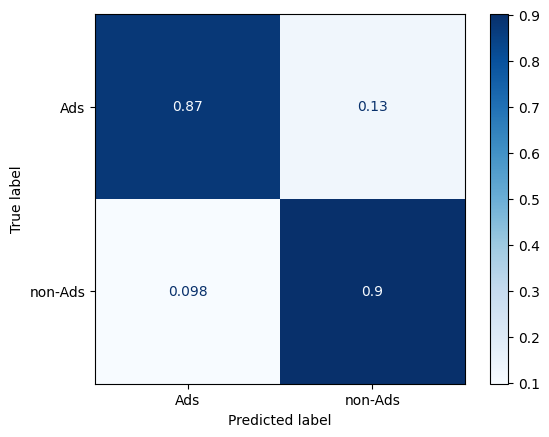

In [72]:
# Plot the confusion matrix
cm_sum = np.sum(cm, axis=1, keepdims=True)
disp = ConfusionMatrixDisplay(confusion_matrix=cm/cm_sum.astype(float), display_labels=['Ads', 'non-Ads'])
disp.plot(cmap=plt.cm.Blues)
plt.show()

In [79]:
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.metrics import f1_score

In [74]:

f1_score(true_labels, predicted_labels)

0.8895100295955277

In [75]:
# precision tp / (tp + fp)
precision = precision_score(true_labels, predicted_labels)
precision

0.8776768332251784

In [76]:
# recall: tp / (tp + fn)
recall = recall_score(true_labels, predicted_labels)
recall

0.9016666666666666

In [77]:
# ROC AUC
auc = roc_auc_score(true_labels, predicted_labels)
print('ROC AUC: %f' % auc)

ROC AUC: 0.888000
